In [1]:
import numpy as np
import os, re, shutil
import ROOT as rt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from root_numpy import tree2array
from lib.histo_utilities import create_TH1D, create_TH2D
from lib.cebefo_style import cebefo_style

Welcome to JupyROOT 6.10/08


In [2]:
cebefo_style()
rt.gStyle.SetStatY(0.98)
rt.gStyle.SetStatX(0.999)
rt.gStyle.SetStatW(0.2)
rt.gStyle.SetStatH(0.1)

In [3]:
input_file = ['../data/DataCMSVMETiming_Run872.root']
validation_file = '../data/test_Run769.root'
i_ch = 14
i_ref = 9
var_ref = 'gaus_mean' + '[{}]'.format(i_ref)
var_ch = 'LP2_10' + '[{}]'.format(i_ch)

In [4]:
chain = rt.TChain('pulse')
for f in input_file:
    root_file = rt.TFile.Open( f,"READ");
    if not root_file:
        print "[ERROR]: Input file not found:", f
        continue
    tree_name = root_file.GetListOfKeys().At(0).GetName()
    if tree_name != 'pulse':
            print 'Wrong name'
            continue
    chain.Add(f)

In [5]:
canvas = {}

info = {i_ch: {}, i_ref:{}}

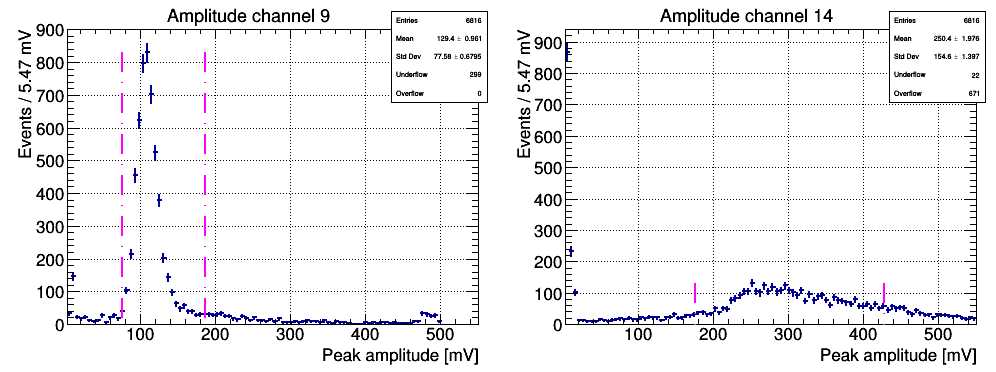

In [6]:
canvas['amp'] = rt.TCanvas('c_amp', 'c_amp', 1000, 400)
canvas['amp'].Divide(2)

for i, k in enumerate([i_ref, i_ch]):
        name = 'h_amp_'+str(k)
        title = 'Amplitude channel '+str(k)

        h = rt.TH1D(name, title, 100, 3, 550)
        h.SetXTitle('Peak amplitude [mV]')
        h.SetYTitle('Events / '+str(h.GetBinWidth(1))+' mV')
        chain.Project(name, 'amp['+str(k)+']')

        h.GetXaxis().SetRange(int(40/5.5)+1,int(450/5.5)+1)
        i_max = h.GetMaximumBin()
        h.GetXaxis().SetRange(1,100)
        peak = h.GetBinCenter(i_max)
        info[k]['amp_range'] = [max(40,peak*0.7), min(470, peak*1.7)]
        info[k]['amp_sel'] = '(amp['+str(k)+'] < ' + str(info[k]['amp_range'][1])
        info[k]['amp_sel'] += ' && '
        info[k]['amp_sel'] += 'amp['+str(k)+'] > ' + str(info[k]['amp_range'][0]) +')'
        
        canvas['amp'].cd(i+1)

        if(k in []):
            canvas['amp'][k].SetLogy()
            
        h.SetLineWidth(2)
        h.DrawCopy('E')

        line = rt.TLine()
        line.SetLineColor(6)
        line.SetLineWidth(2)
        line.SetLineStyle(10)
        line.DrawLine(info[k]['amp_range'][0], 0, info[k]['amp_range'][0], h.GetBinContent(i_max))
        line.DrawLine(info[k]['amp_range'][1], 0, info[k]['amp_range'][1], h.GetBinContent(i_max))

canvas['amp'].Update()
canvas['amp'].Draw()

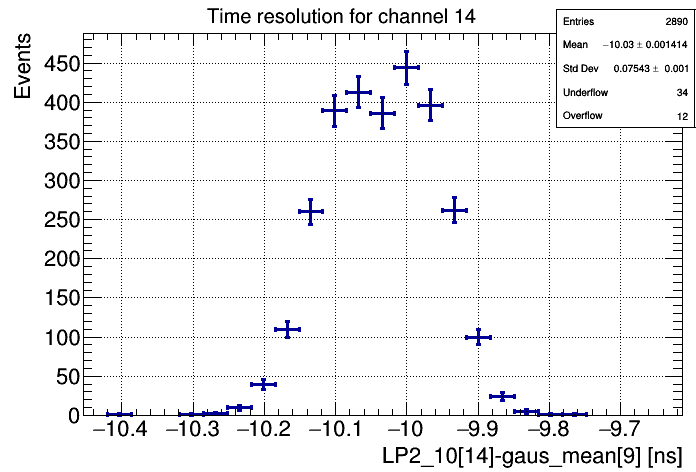

In [7]:
var_dT = var_ch + '-' + var_ref
selection = info[i_ch]['amp_sel'] +' * ' + info[i_ref]['amp_sel'] + ' * (ntracks>0)'

delta_t = (tree2array(chain, var_dT, selection).view(np.recarray).T)[0]


median = np.percentile(delta_t, 50)
width = np.abs(np.percentile(delta_t, 20) - np.percentile(delta_t, 80))

h = create_TH1D(delta_t, 'h_delta_t_raw_'+str(k), 'Time resolution for channel '+str(k),
                    binning = [ None, median-3*width, median+3*width],
                    axis_title = [var_dT+' [ns]', 'Events'])

low_edge = min(h.GetBinCenter(h.GetMaximumBin()-3), np.percentile(delta_t, 10))
upper_edge = min(h.GetBinCenter(h.GetMaximumBin()+4), np.percentile(delta_t, 90))

# res = h.Fit('gaus', 'LQSR', '', low_edge, upper_edge)

canvas['t_res_raw'] = rt.TCanvas('c_t_res_raw_'+str(k), 'c_t_res_raw_'+str(k), 700, 500)
h.DrawCopy('E1')
canvas['t_res_raw'].Update()
canvas['t_res_raw'].Draw()

selection += '* ({}>{} && {}<{})'.format(var_dT, median-3*width, var_dT, median+3*width)
delta_t = (tree2array(chain, var_dT, selection).view(np.recarray).T)[0]

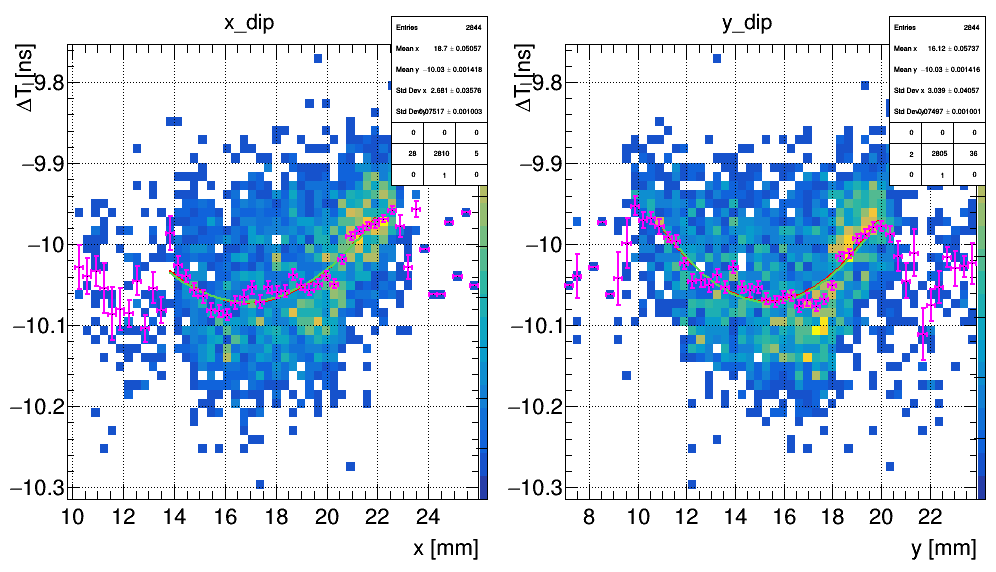

In [8]:
arr = {}
canvas['corr'] = rt.TCanvas('c_corr', 'c_corr', 1000, 600)
canvas['corr'].Divide(2)
add_sel = ''

for i, c in enumerate(['x', 'y']):
    info[c] = {}
    pos = (tree2array(chain, c+'_dut[0]', selection).view(np.recarray).T)[0]
    info[c]['pl'] = np.percentile(pos, 5)
    info[c]['ph'] = np.percentile(pos, 90)
    add_sel += '*('+c+'_dut[0] > ' + str(info[c]['pl']) + ' && '+c+'_dut[0] < ' + str(info[c]['ph']) + ')'
    
    canvas['corr'].cd(i+1)
    h = create_TH2D(np.column_stack((pos, delta_t)), name=c+'_dip', title=c+'_dip',
                    binning=[50, info[c]['pl']-4, info[c]['ph']+4, 50, median-2*width, median+2*width],
                    axis_title=[c+' [mm]', '#DeltaT [ns]']
                   )
    
    h.DrawCopy('COLZ')
    h.SetLineColor(2)
    
    prof = h.ProfileX('prof_'+c )
    prof.SetLineColor(6)
    prof.SetLineWidth(2)
    
    f = rt.TF1(c+'_fit','[0]+[1]*x+[2]*x^2',info[c]['pl'], info[c]['ph'])
    prof.Fit(c+'_fit', 'QN0R')
    f.SetLineColor(2)
    f.DrawCopy('SAMEL')
    
    aux_t = delta_t[np.logical_and(pos>info[c]['pl'], pos<info[c]['ph'])]
    pos = pos[np.logical_and(pos>info[c]['pl'], pos<info[c]['ph'])]
    coeff, r, rank, s = np.linalg.lstsq(np.column_stack((0*pos+1, pos, pos**2)), aux_t)
    for j,a in enumerate(coeff):
        f.SetParameter(j, a)
    info[c]['coeff'] = np.flip(coeff, 0)
    f.SetLineColor(8)
    f.DrawCopy('SAMEL')
    
    prof.DrawCopy('SAMEE1')
    
canvas['corr'].Update()
canvas['corr'].Draw()
    
selection += add_sel
arr['x'] = (tree2array(chain, 'x_dut[0]', selection).view(np.recarray).T)[0]
arr['y'] = (tree2array(chain, 'y_dut[0]', selection).view(np.recarray).T)[0]
delta_t = (tree2array(chain, var_dT, selection).view(np.recarray).T)[0]

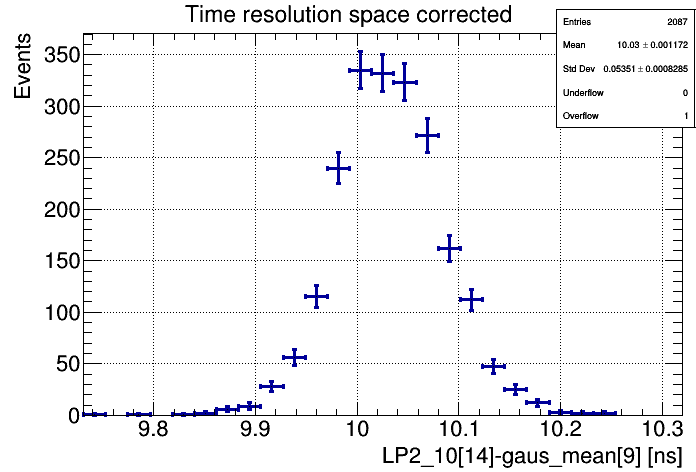

In [9]:
dt_space_corrected = np.copy(delta_t)
for c in ['x', 'y']:
    dt_space_corrected -= np.polyval(info[c]['coeff'], arr[c])
        
h = create_TH1D(dt_space_corrected, 'h_delta_space_corr', 'Time resolution space corrected',
                binning = [ None, np.min(dt_space_corrected), np.max(dt_space_corrected)],
                axis_title = [var_dT+' [ns]', 'Events'])

canvas['t_res_space'] = rt.TCanvas('c_t_res_space', 'c_t_res_raw', 700, 500)
h.DrawCopy('E1')
canvas['t_res_space'].Update()
canvas['t_res_space'].Draw()

0.0646024601173


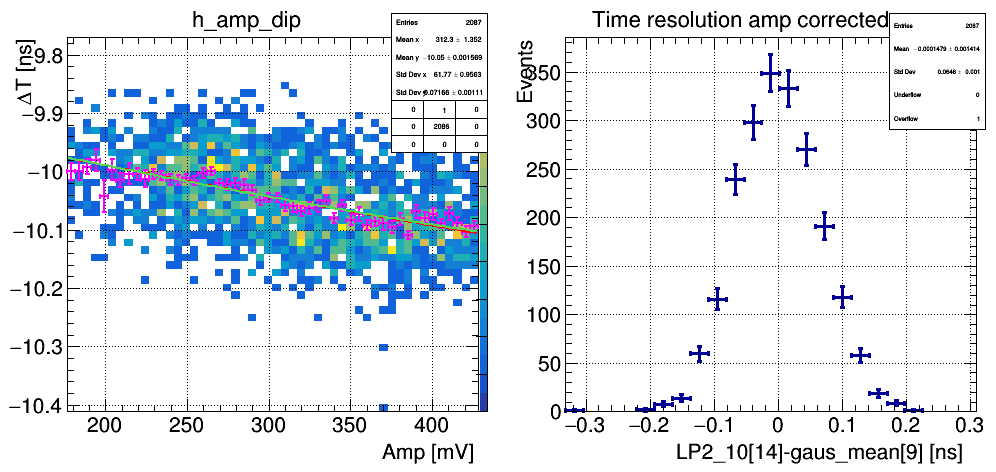

In [10]:
info['amp'] = {}
arr['amp'] = (tree2array(chain, 'amp['+str(i_ch)+']', selection).view(np.recarray).T)[0]
canvas['dt_vs_amp'] = rt.TCanvas('dt_vs_amp', 'dt_vs_amp', 1000, 500)
canvas['dt_vs_amp'].Divide(2)

h = create_TH2D(np.column_stack((arr['amp'], delta_t)), name='h_amp_dip', title='h_amp_dip',
                    binning=[50, info[i_ch]['amp_range'][0], info[i_ch]['amp_range'][1], 50, np.min(delta_t), np.max(delta_t)],
                    axis_title=['Amp [mV]', '#DeltaT [ns]']
                   )
canvas['dt_vs_amp'].cd(1)
h.DrawCopy('colz')
prof = h.ProfileX('prof_amp')
prof.SetLineColor(6)
prof.SetLineWidth(2)
prof.DrawCopy('SAMEE1')

f = rt.TF1('amp_fit','[0]+[1]*x+[2]*x^2', info[i_ch]['amp_range'][0], info[i_ch]['amp_range'][1])
prof.Fit('amp_fit', 'QN0R')
f.SetLineColor(2)
f.DrawCopy('SAMEL')

coeff, r, rank, s = np.linalg.lstsq(np.column_stack((0*arr['amp']+1, arr['amp'], arr['amp']**2)), delta_t)
for j,a in enumerate(coeff):
    f.SetParameter(j, a)
info['amp']['coeff'] = np.flip(coeff, 0)
f.SetLineColor(8)
f.DrawCopy('SAMEL')


dt_amp_corrected = np.copy(delta_t) - np.polyval(info['amp']['coeff'], arr['amp'])
        
h = create_TH1D(dt_amp_corrected, 'h_delta_amp_corr', 'Time resolution amp corrected',
                binning = [ None, np.min(dt_amp_corrected), np.max(dt_amp_corrected)],
                axis_title = [var_dT+' [ns]', 'Events'])
canvas['dt_vs_amp'].cd(2)
h.DrawCopy('E1')
print h.GetRMS()

canvas['dt_vs_amp'].Update()
canvas['dt_vs_amp'].Draw()

0.0545093251054


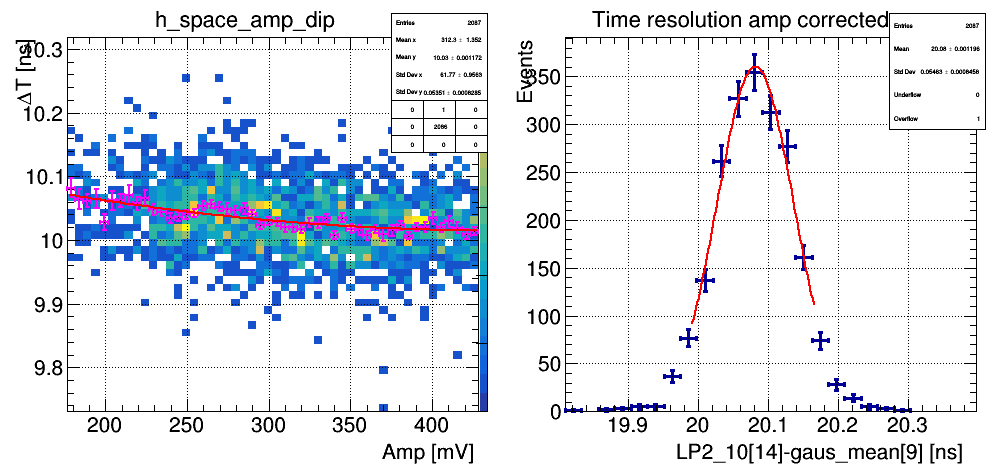

In [11]:
canvas['dtcorr_vs_amp'] = rt.TCanvas('dtcorr_vs_amp', 'dtcorr_vs_amp', 1000, 500)
canvas['dtcorr_vs_amp'].Divide(2)

h = create_TH2D(np.column_stack((arr['amp'], dt_space_corrected)), name='h_space_amp_dip', title='h_space_amp_dip',
                    binning=[50, info[i_ch]['amp_range'][0], info[i_ch]['amp_range'][1], 50, np.min(dt_space_corrected), np.max(dt_space_corrected)],
                    axis_title=['Amp [mV]', '#DeltaT [ns]']
                   )
canvas['dtcorr_vs_amp'].cd(1)
h.DrawCopy('colz')
prof = h.ProfileX('prof_corr_amp')
prof.SetLineColor(6)
prof.SetLineWidth(2)
prof.DrawCopy('SAMEE1')

f = rt.TF1('f_tcorr_amp_fit','[0]+[1]*x+[2]*x^2', info[i_ch]['amp_range'][0], info[i_ch]['amp_range'][1])
prof.Fit('f_tcorr_amp_fit', 'QN0R')
f.SetLineColor(2)
f.DrawCopy('SAMEL')

coeff, r, rank, s = np.linalg.lstsq(np.column_stack((0*arr['amp']+1, arr['amp'], arr['amp']**2)), delta_t)
for j,a in enumerate(coeff):
    f.SetParameter(j, a)
info['amp']['coeff_space_corr'] = np.flip(coeff, 0)
f.SetLineColor(8)
f.DrawCopy('SAMEL')


dt_amp_corrected = np.copy(dt_space_corrected) - np.polyval(info['amp']['coeff_space_corr'], arr['amp'])
        
h = create_TH1D(dt_amp_corrected, 'h_delta_amp_corr', 'Time resolution amp corrected',
                binning = [ None, np.min(dt_amp_corrected), np.max(dt_amp_corrected)],
                axis_title = [var_dT+' [ns]', 'Events'])
f = rt.TF1('f_all_corr','gaus', np.percentile(dt_amp_corrected, 5), np.percentile(dt_amp_corrected, 95))
h.Fit('f_all_corr', 'QN0R')
canvas['dtcorr_vs_amp'].cd(2)
h.DrawCopy('E1')
f.SetLineColor(2)
f.DrawCopy('SAMEL')
print f.GetParameter(2)

canvas['dtcorr_vs_amp'].Update()
canvas['dtcorr_vs_amp'].Draw()

In [12]:
def create_regression_input(x, y, amp):
    out = (np.ones_like(x), x, y, amp, x**2, y**2, amp**2, x*y, amp*x, amp*y)
    return np.column_stack(out)

0.0484915411183


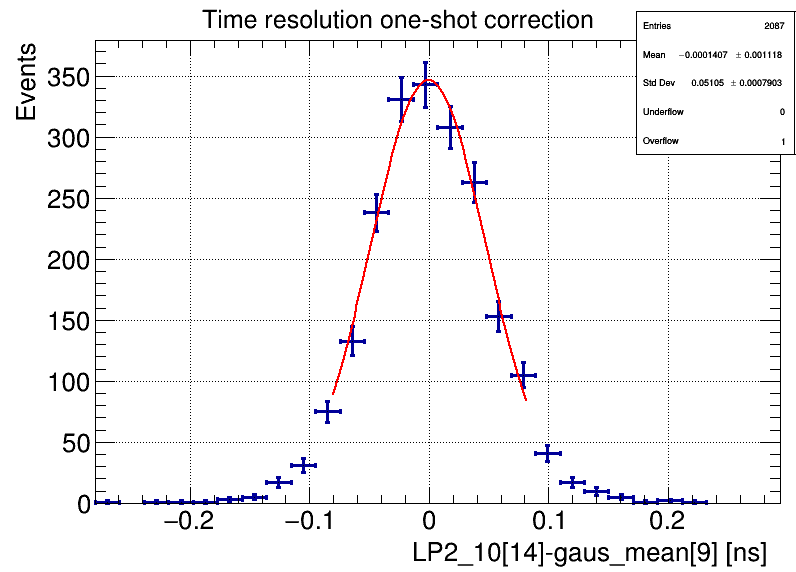

In [13]:
inputs = create_regression_input(arr['x'], arr['y'], arr['amp'])
coeff, r, rank, s = np.linalg.lstsq(inputs, delta_t)

dt_corr = delta_t - np.dot(inputs, coeff)
        
h = create_TH1D(dt_corr, 'h_dt_corr', 'Time resolution one-shot correction',
                binning = [ None, np.min(dt_corr), np.max(dt_corr)],
                axis_title = [var_dT+' [ns]', 'Events'])
f = rt.TF1('f_corr','gaus', np.percentile(dt_corr, 5), np.percentile(dt_corr, 95))
h.Fit('f_corr', 'QN0R')
canvas['dt_corr'] = rt.TCanvas('c_dt_corr', 'aaaa', 800, 600)
h.DrawCopy('E1')
f.SetLineColor(2)
f.DrawCopy('SAMEL')
print f.GetParameter(2)

canvas['dt_corr'].Update()
canvas['dt_corr'].Draw()